<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/sudoku_rec/sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap -q

In [23]:
import cv2
import numpy as np
from urllib.request import urlopen, urlretrieve
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm    
import random
from deap import creator, base, tools, algorithms
from tensorflow.keras.models import load_model

In [3]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/sudoku_rec/res/target.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)

base_img = cv2.imdecode(arr, -1)
base_h, base_w, _ = base_img.shape

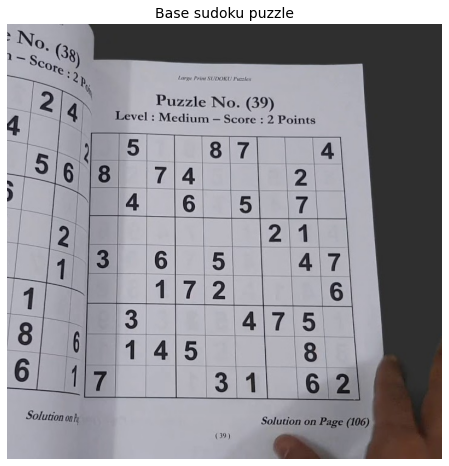

In [4]:
plt.figure(figsize = (16, 8))
plt.axis("off")
plt.title("Base sudoku puzzle", fontsize=14)
plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))

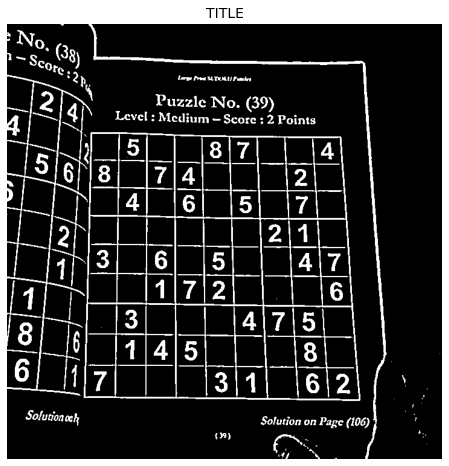

In [6]:
base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
base_blur = cv2.GaussianBlur(base_gray, (5, 5), 1)
base_th = cv2.adaptiveThreshold(base_blur, 255, 1, 1, 11, 3)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_th, cv2.COLOR_BGR2RGB))

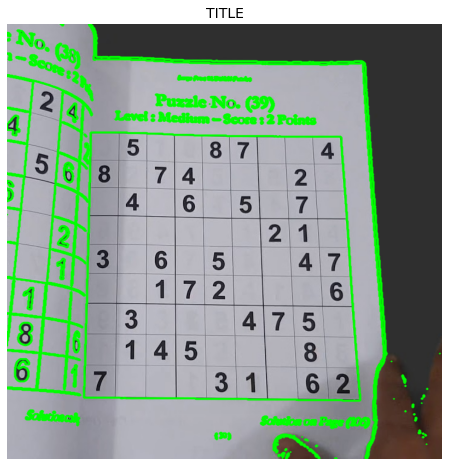

In [7]:
cnts, hr = cv2.findContours(base_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnt_img = base_img.copy()
cv2.drawContours(image=cnt_img, contours=cnts, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(cnt_img, cv2.COLOR_BGR2RGB))

In [11]:
biggest_contour = None
biggest_contour_area = 0
corners = []

for c in cnts:
    area = cv2.contourArea(c)
    if area > 100:
        p = cv2.arcLength(c, True)
        apx = cv2.approxPolyDP(c, 0.02 * p, True)
        if area > biggest_contour_area and len(apx) == 4:
            corners = apx
            biggest_contour_area = area
            biggest_contour = c

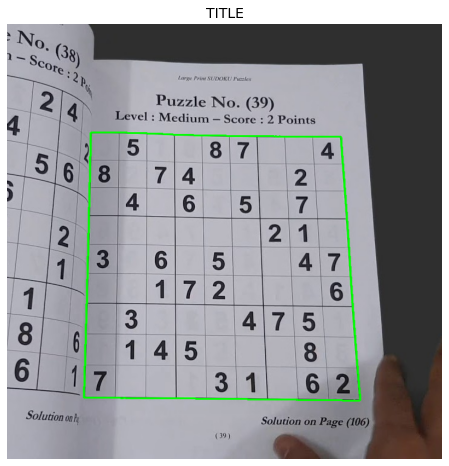

In [9]:
base_big_cnt = base_img.copy()
cv2.drawContours(image=base_big_cnt, contours=biggest_contour, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_big_cnt, cv2.COLOR_BGR2RGB))

In [12]:
corners_tmp = corners.copy()
corners_tmp = corners_tmp.reshape((4, 2))
corners = np.zeros((4, 1, 2), dtype=np.int32)
s = corners_tmp.sum(1)
corners[0] = corners_tmp[np.argmin(s)]
corners[3] = corners_tmp[np.argmax(s)]
d = np.diff(corners_tmp, axis=1)
corners[1] = corners_tmp[np.argmin(d)]
corners[2] = corners_tmp[np.argmax(d)]

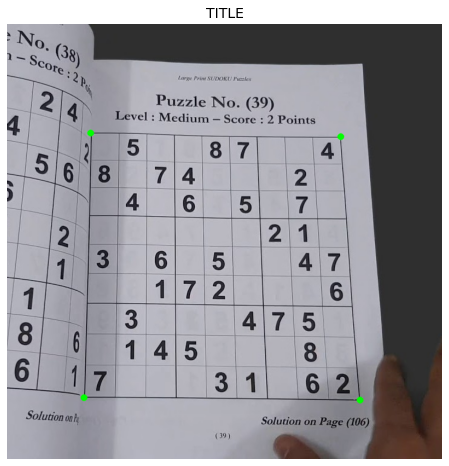

In [14]:
base_corners = base_img.copy()
cv2.drawContours(image=base_corners, contours=corners, contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_corners, cv2.COLOR_BGR2RGB))

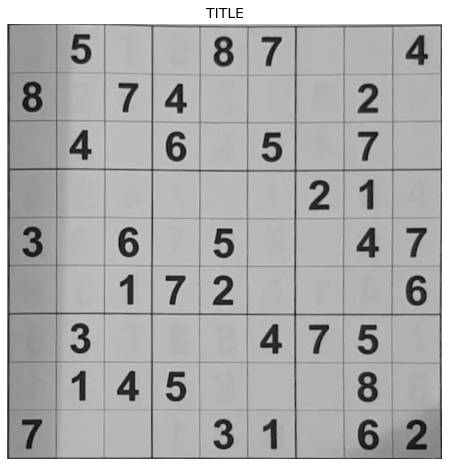

In [16]:
current = np.float32(corners)
wraped = np.float32([[0, 0], [base_w, 0], [0, base_h], [base_w, base_h]])

persp_matrix = cv2.getPerspectiveTransform(current, wraped)

sk_im = cv2.warpPerspective(base_img, persp_matrix, (base_w, base_h))
sk_im = cv2.cvtColor(sk_im, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(sk_im, cv2.COLOR_BGR2RGB))

In [17]:
cells = []
rows = np.vsplit(sk_im, 9)
for row in rows:
    cols = np.hsplit(row, 9)
    for cell in cols:
        cells.append(cell)

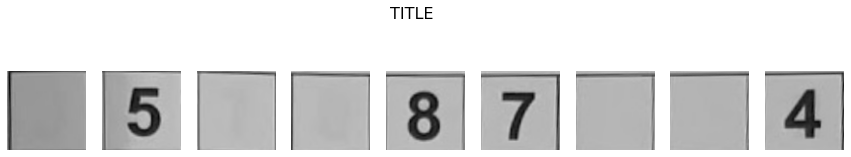

In [20]:
fig, axs = plt.subplots(1, 9, figsize=(15,3))
fig.suptitle("TITLE", fontsize=16)
for i, im in enumerate(cells[:9]):
    axs[i].axis("off")
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [22]:
urlretrieve('https://github.com/jafetimbre/ms-school-stuff/raw/master/image-processing/sudoku_rec/res/model.h5', 'model.h5')
MODEL_PATH = './model.h5'

In [24]:
model = load_model(MODEL_PATH)

In [25]:
results = []

for cell in cells:
    cell_im = np.asarray(cell)
    cell_im = cell_im[4:cell_im.shape[0]-4, 4:cell_im.shape[1]-4]
    cell_im = cv2.resize(cell_im, (28, 28))
    cell_im = cell_im / 255
    cell_im = cell_im.reshape(1, 28, 28, 1)

    pred = model.predict(cell_im)
    val_idx = np.argmax(pred, axis=-1)
    probVal = np.amax(pred)

    if probVal > .8:
        results.append(val_idx[0])
    else:
        results.append(0)

In [26]:
print(results)

[0, 5, 0, 0, 8, 1, 0, 0, 4, 8, 0, 7, 4, 0, 0, 0, 2, 0, 0, 4, 0, 6, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 6, 0, 5, 0, 0, 4, 7, 0, 0, 1, 7, 2, 0, 0, 0, 6, 0, 3, 0, 0, 0, 4, 7, 5, 0, 0, 1, 4, 5, 0, 0, 0, 8, 0, 7, 0, 0, 0, 3, 1, 0, 6, 2]


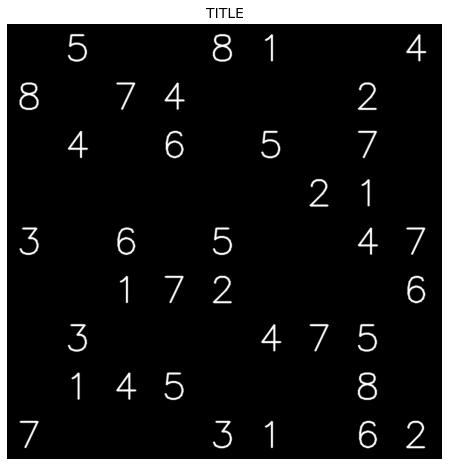

In [35]:
sk_im_w, sk_im_h = sk_im.shape
sk_unsolved = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
im_s_w = int(sk_unsolved.shape[1]/9)
im_s_h = int(sk_unsolved.shape[0]/9)

for i in range(0, 9):
    for j in range(0, 9):
        val = results[(i*9)+j]
        if val != 0:
            cv2.putText(sk_unsolved, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(sk_unsolved, cv2.COLOR_BGR2RGB))

In [36]:
BOARD_CONFIG = []

for idx, val in enumerate(results):
    if (val > 0):
        i = int(idx / 9)
        j = idx % 9
        BOARD_CONFIG.append((val, i, j))

BOARD_CONFIG = np.asarray(BOARD_CONFIG)
print(BOARD_CONFIG)

[[5 0 1]
 [8 0 4]
 [1 0 5]
 [4 0 8]
 [8 1 0]
 [7 1 2]
 [4 1 3]
 [2 1 7]
 [4 2 1]
 [6 2 3]
 [5 2 5]
 [7 2 7]
 [2 3 6]
 [1 3 7]
 [3 4 0]
 [6 4 2]
 [5 4 4]
 [4 4 7]
 [7 4 8]
 [1 5 2]
 [7 5 3]
 [2 5 4]
 [6 5 8]
 [3 6 1]
 [4 6 5]
 [7 6 6]
 [5 6 7]
 [1 7 1]
 [4 7 2]
 [5 7 3]
 [8 7 7]
 [7 8 0]
 [3 8 4]
 [1 8 5]
 [6 8 7]
 [2 8 8]]


ALG GEN

In [45]:
def individual_to_board(individual):
    flat_init_state_indx = list(map(lambda t: t[1]*9 + t[2], BOARD_CONFIG))
    values = BOARD_CONFIG.T[0]
    flat_board = []
    init_values_count = 0

    for i in range(81):
        if (i in flat_init_state_indx):
            flat_board.append(values[init_values_count])
            init_values_count += 1
            continue
        flat_board.append(individual[i - init_values_count])
    return np.array(flat_board).reshape(9,9)

In [48]:
def draw_board_from_ind(individual):
    board_from_ind = individual_to_board(individual)
    draw_board(board_from_ind)

In [43]:
def individual_fitness(individual):
    board_from_ind = individual_to_board(individual)
    return board_fitness(board_from_ind),

In [41]:
def board_fitness(board_state):
    fitness = 0
    nr_rows, nr_cols = board_state.shape

    # Verificarea liniilor si a coloanelor dupa elemente comune
    for row in board_state:
        fitness += len(np.unique(row))
    for col in board_state.T:
        fitness += len(np.unique(col))

    # Verificarea sub patratelor dupa elemente comune
    for i in range(0, 3):
        for j in range(0, 3):
            board_group = board_state[3*i:3*i+3, 3*j:3*j+3]
            fitness += len(np.unique(board_group))
    
    return fitness

In [56]:
def draw_board(board_state):
    sk_im_w, sk_im_h = sk_im.shape
    im = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
    im_s_w = int(im.shape[1]/9)
    im_s_h = int(im.shape[0]/9)

    board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))

    for i in range(0, 9):
        for j in range(0, 9):
            val = board_state[i][j]
            if (i, j) in board_conf_cords:
                cv2.putText(im, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (255, 255, 255), 5, cv2.LINE_AA)
            else:
                cv2.putText(im, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title("Board state", fontsize=14)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [39]:
def generate_random_individual():
    board = (np.indices((9,9)) + 1)[1]

    for i in range(len(board)):
        board[i] = np.random.permutation(board[i])
    
    for (val, row, col) in BOARD_CONFIG:
        value_index = np.where(board[row]==val)[0][0]
        board[row][value_index], board[row][col] = board[row][col], board[row][value_index]

    fixed_values_mask = np.ones((9,9), dtype=bool)
    for (val, row, col) in BOARD_CONFIG:
        fixed_values_mask[row][col] = False

    return board[fixed_values_mask].tolist()


The fitness of the test individual is: 200/243


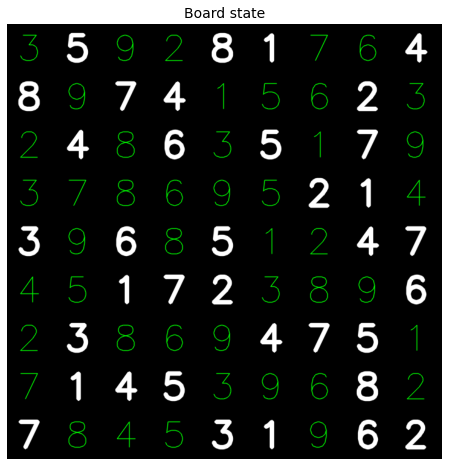

In [57]:
test_individual = generate_random_individual()
fintess_test_ind = individual_fitness(test_individual)

draw_board_from_ind(test_individual)
print(f'\nThe fitness of the test individual is: {fintess_test_ind[0]}/243')

In [58]:
def ea_simple_elitist(population, toolbox, cxpb, mutpb, ngen, callback=None, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        # elitist version
        raise ValueError("halloffame parameter must not be empty!")
    
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        # Selecting the individuals for the next generation
        # (except the elit individuals witch are copied: -hof_size)
        offspring = toolbox.select(population, len(population) - hof_size)
    
        # Aplicam operatorii de variatie
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluam fitnessul unde este necesar 
        # (s-a modificat cromozomul, fitnesul vechi a devenit invalid)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # mecanism elitist, copiem cei mai bunzi indivizi fin halloffame in mod automat
        offspring.extend(halloffame.items)

        # Actualizam halloffame cu descendentii creati
        halloffame.update(offspring)

        # Inlocuim populatia actuala cu descendentii (ce contin si indivizii copiati in mod elitist)
        population[:] = offspring

        # Adaugam statisticile populatiei obtinute in logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        if callback:
            callback(gen, halloffame.items[0])

    return population, logbook

In [59]:
NR_POPULATION = 5000
NR_GENERATIONS = 50

MUTATION_PROB = 0.3
CROSSOVER_PROB = 0.8

HOF_SIZE = 10
TOURNAMENT_SIZE = 3

In [60]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [61]:
toolbox = base.Toolbox()

toolbox.register('gen_rand_ind', generate_random_individual)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.gen_rand_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [62]:
toolbox.register("evaluate", individual_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=9, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

population = toolbox.population(n=NR_POPULATION)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("std", np.std)

hof = tools.HallOfFame(HOF_SIZE)

In [64]:
%%time
population, logbook = ea_simple_elitist(population,
                                        toolbox,
                                        cxpb=CROSSOVER_PROB,
                                        mutpb=MUTATION_PROB,
                                        ngen=NR_GENERATIONS,
                                        stats=stats,
                                        halloffame=hof,
                                        verbose=True)

gen	nevals	min	max	avg    	std    
0  	5000  	184	217	199.476	4.32821
1  	4227  	186	217	200.919	4.13108
2  	4273  	187	219	201.983	4.1648 
3  	4321  	184	219	202.981	4.17493
4  	4214  	187	222	203.943	4.25768
5  	4259  	190	222	205.005	4.31154
6  	4320  	190	222	206.068	4.39288
7  	4257  	188	222	207.173	4.40251
8  	4238  	191	225	208.404	4.45954
9  	4357  	188	227	209.581	4.47824
10 	4259  	190	227	210.958	4.46993
11 	4321  	193	227	212.215	4.43345
12 	4300  	196	228	213.391	4.51137
13 	4278  	198	228	214.691	4.43327
14 	4310  	195	231	216.076	4.46119
15 	4295  	202	232	217.502	4.39245
16 	4338  	201	232	218.82 	4.32783
17 	4307  	202	233	220.17 	4.21942
18 	4324  	204	235	221.411	4.25746
19 	4298  	205	237	222.683	4.22879
20 	4278  	204	237	224.019	4.26153
21 	4232  	205	240	225.467	4.33448
22 	4291  	206	240	226.902	4.26833
23 	4254  	210	240	228.444	4.19186
24 	4334  	209	240	229.776	4.10937
25 	4335  	214	240	231.099	3.85861
26 	4271  	212	240	232.125	3.82642
27 	4279  	213	240	2

In [68]:
best = hof.items[0]
best_solution = best.copy()
print(f"Best Solution: {best_solution}")
print(f"Best Score: {best.fitness.values[0]} / 243\n")

Best Solution: [2, 3, 7, 6, 9, 6, 9, 3, 1, 5, 1, 9, 2, 3, 8, 5, 7, 8, 3, 4, 6, 9, 2, 1, 9, 8, 4, 9, 8, 5, 3, 9, 2, 8, 6, 1, 6, 7, 2, 9, 3, 8, 5, 9, 4]
Best Score: 240.0 / 243



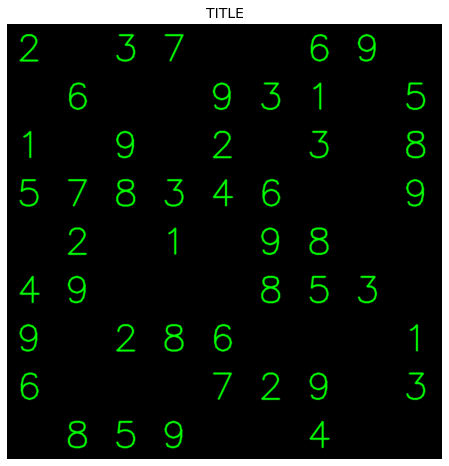

In [69]:
sk_im_w, sk_im_h = sk_im.shape
sk_solved = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
im_s_w = int(sk_solved.shape[1]/9)
im_s_h = int(sk_solved.shape[0]/9)

board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))
loc_best = best.copy()

for i in range(0, 9):
    for j in range(0, 9):
        if (i, j) not in board_conf_cords:
            val = loc_best.pop(0)
            cv2.putText(sk_solved, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(sk_solved, cv2.COLOR_BGR2RGB))

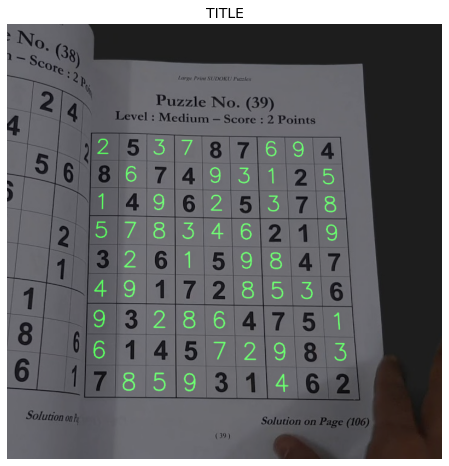

In [75]:
current = np.float32(corners)
wraped = np.float32([[0, 0], [base_w, 0], [0, base_h], [base_w, base_h]])

persp_matrix = cv2.getPerspectiveTransform(wraped, current)

base_solved = cv2.warpPerspective(sk_solved, persp_matrix, (base_w, base_h))
base_solved = cv2.addWeighted(base_solved, 1, base_img, 0.6, 1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_solved, cv2.COLOR_BGR2RGB))